In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def arith(n):
    return int(n*(n+1)/2)

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class LatSim(nn.Module):
    def __init__(self, nTgts, dp=0.5, dp2=0.1, method='same'):
        super(LatSim, self).__init__()
        self.nTgts = nTgts
        self.method = method
        self.masks = []
        if method == 'same':
            nMasks = nTgts
        elif method == 'diff':
            nMasks = 2*nTgts
        elif method == 'univ':
            nMasks = nTgts+1
        for i in range(nMasks):
            self.masks.append(nn.Parameter(
                1e-4*torch.randn(arith(263),2).float().cuda()
            ))
        self.masks = nn.ParameterList(self.masks)
        self.dp = nn.Dropout(p=dp)
        self.dp2 = nn.Dropout(p=dp2)
    
    def getLatentsAndEdges(self, x, i):
        if self.method == 'univ':
            y = torch.einsum('ac,ce->ae', x, self.masks[0])
            z = torch.einsum('ac,ce->ae', x, self.masks[i+1])
            e = y@z.T
            e = e+e.T
            return y, z, e
        elif self.method == 'diff':
            y = torch.einsum('ac,ce->ae', x, self.masks[2*i])
            z = torch.einsum('ac,ce->ae', x, self.masks[2*i+1])
            e = y@z.T
            e = e+e.T
            return y, z, e
        elif self.method == 'same':
            y = torch.einsum('ac,ce->ae', x, self.masks[i])
            e = y@y.T
            return y, y, e
        
    def forward(self, x, y, testIdcs=None):
        x = self.dp(x)
        res = []
        es = []
        for i in range(self.nTgts):
            nClass = y.shape[1] if y.dim() == 2 else 1
            _, _, e = self.getLatentsAndEdges(x[:,i,:], i)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = self.dp2(e)
            e = mask(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e, dim=1)
            es.append(e)
            res.append(e@y)
        return res, es
    
mseLoss = nn.MSELoss()

sim = LatSim(2, 0.5, 0.1, 'same')
print(sim.masks[0].shape)
print(sim.masks[0][0:5,0:5])

sim.load_state_dict(torch.load('../../Work/LatentSim/sim.pyt'))

print(sim.masks[0].shape)
print(sim.masks[0][0:5,0:5])

torch.Size([34716, 2])
tensor([[ 4.9446e-05,  1.3363e-04],
        [-8.1251e-05,  3.1103e-05],
        [ 1.2255e-04, -1.4656e-04],
        [ 1.9221e-05,  5.5420e-05],
        [-5.4122e-05, -1.5181e-05]], device='cuda:0', grad_fn=<SliceBackward0>)
torch.Size([34716, 2])
tensor([[-0.0017, -0.0011],
        [-0.0021,  0.0019],
        [ 0.0066, -0.0011],
        [ 0.0011,  0.0003],
        [ 0.0015,  0.0040]], device='cuda:0', grad_fn=<SliceBackward0>)


In [3]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [4]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [6]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [7]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [8]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [9]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

(620,)
(620, 2)
(620,)


In [10]:
age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

Complete


In [70]:
Y0 = torch.einsum('ab,bc->abc', nback_p_t, sim.masks[0])
Y1 = torch.einsum('ab,bc->abc', emoid_p_t, sim.masks[1])

print(Y0.shape)
print(Y1.shape)

torch.Size([620, 34716, 2])
torch.Size([620, 34716, 2])


In [71]:
idcs = torch.argsort(age_t)
Y0sort = Y0[idcs,:,:]
Y1sort = Y1[idcs,:,:]

print('Complete')

Complete


In [72]:
parts = []
step = 100

for i in range(0,40000,step):
    if i >= Y0.shape[1]:
        break
    part = Y0sort[:,i:i+step,:]
    subConnSim = torch.einsum('abc,dbc->adb', part, part)
    subConnR = torch.einsum('adb,ad->b', subConnSim, mat)
    parts.append(subConnR.detach().cpu().numpy())
    
parts = np.concatenate(parts)

In [75]:
with open('../../Work/LatentSim/IndividualConnTopDiscrimination/Top0.pkl', 'wb') as f:
    pickle.dump(parts, f)
    
print('Complete')

Complete


In [74]:
idcs = np.argsort(parts)[-50:]
# print(idcs)
print(parts[idcs])

mx, my = np.triu_indices(264,1)
lst = []
for idx in idcs:
    lst.append((mx[idx],my[idx]))
    
print(lst)

[330.28424 334.32587 338.79987 338.92282 340.5786  341.66486 343.441
 345.31577 345.79144 345.80542 350.26547 354.89706 355.12613 355.2255
 355.43973 355.85068 355.96155 358.54398 362.60916 374.2465  377.40222
 377.59244 379.92172 381.41913 382.70822 384.05676 386.7398  388.18344
 389.08145 392.05798 392.8709  393.86743 394.27048 401.19864 402.50116
 404.9338  406.28104 406.31494 407.19077 413.11014 425.3119  427.06113
 427.89108 448.5332  448.79153 458.45044 462.03574 480.82104 529.38324
 602.4207 ]
[(90, 91), (11, 94), (62, 64), (19, 26), (81, 180), (207, 258), (41, 223), (92, 94), (77, 180), (3, 9), (167, 197), (75, 184), (90, 200), (89, 255), (86, 94), (64, 155), (126, 233), (52, 53), (20, 193), (35, 224), (69, 224), (52, 210), (102, 108), (222, 233), (181, 249), (74, 77), (97, 216), (180, 181), (222, 252), (173, 192), (254, 259), (75, 107), (1, 92), (52, 229), (84, 216), (84, 210), (101, 115), (82, 115), (140, 256), (64, 162), (15, 202), (65, 241), (85, 201), (62, 226), (174, 215)

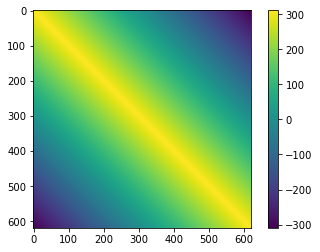

In [30]:
import matplotlib.pyplot as plt

mat0 = torch.arange(620).unsqueeze(1)
mat1 = torch.arange(620).unsqueeze(0)
mat = 310-torch.abs(mat0-mat1).float().cuda()

plt.imshow(mat.detach().cpu().numpy())
plt.colorbar()
plt.show()

In [108]:
def selectRoi(Y, roi):
    sel = torch.zeros(264,264,dtype=bool)
    sel[roi,:] = True
    sel[:,roi] = True
    sel = sel[torch.triu_indices(264,264,offset=1).unbind()]
    return Y[:,sel,:]

idcs = torch.argsort(age_t)
simData = torch.zeros(264,620,620)

for i in range(264):
    roi = selectRoi(Y1.detach(), i)
    simRoi = torch.einsum('abc,xbc->ax', roi, roi).cpu()
    simRoi = simRoi[idcs,:]
    simRoi = simRoi[:,idcs]
    simData[i,:,:] = simRoi
    if i % 50 == 0:
        print(f'done {i}')

done 0
done 50
done 100
done 150
done 200
done 250


In [109]:
big = torch.mean(simData[:,300:,300:], dim=(1,2))-torch.mean(simData[:,300:,:300], dim=(1,2))
torch.argsort(big)

tensor([ 92,  74,  26,  94,  77, 231, 185, 131, 203, 180,  90,  93, 174, 114,
         86,  45,  36,   2, 138,  78, 133,  89, 191, 230,  72, 225, 198, 246,
        139,  61,  28,  10,  84,  82, 220,  16,  95,  53, 170, 213, 157,  85,
         49, 119, 240, 117, 126,  83, 148, 176, 128,  69, 192,   8, 125,  23,
        181, 260,   5, 237, 201, 196, 120,  79, 150, 195, 136, 100,  57, 247,
         99, 186, 189, 105,  64,  91, 115, 101,   6, 132,  62, 179, 183,  73,
        177,   4,  42, 134, 143, 194, 226, 188, 160,  65, 129, 202, 253, 218,
        145, 217, 171, 107,  54, 106, 102,  38, 199, 184, 263,  96, 219, 228,
         41, 124,  75, 238,  13, 109, 255,  71, 197, 175, 146,  30, 187, 108,
        239, 233, 236, 206, 153,  87, 224,  97, 182, 113, 205, 200, 243, 172,
         19, 211, 118, 168, 222,  25,  70,   0,  67, 167, 122,  34,  46, 140,
        235, 256, 111,  50, 135,  88,  59, 261,  48, 216, 163, 110, 162, 210,
         66,  12, 164, 104, 223, 137, 190, 204, 254, 178, 241,  

tensor(-1.2892e-05)


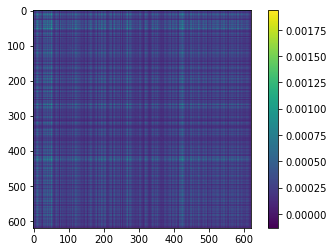

In [123]:
import matplotlib.pyplot as plt
print(big[22])
plt.imshow(simData[22,:,:].detach().cpu().numpy())
plt.colorbar()
plt.show()

In [214]:
import torch.nn.functional as F

topRois = []
topVals = []

simDataSubj = torch.mean(simData[:,:,480:], dim=2)-torch.mean(simData[:,:,:480], dim=2)#-torch.mean(simData[:,:,400:], dim=2)
for i in range(480,620):
    vals, idcs = torch.sort(simDataSubj[:,i])
    topRois.append(idcs[vals > 0][-10:])
    topVals.append(vals[vals > 0][-10:])
    
print('Complete')

Complete


/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


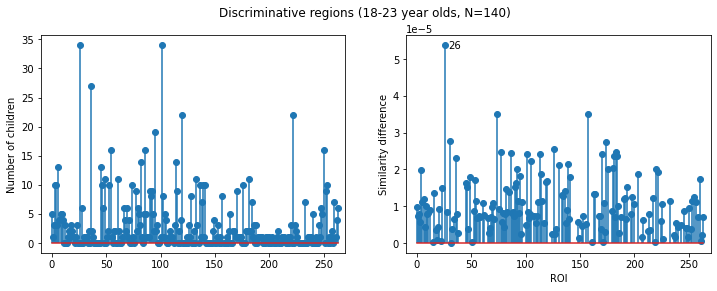

In [222]:
tr = torch.cat(topRois)
tv = torch.cat(topVals)
valsByRoi = torch.zeros(264)
bins = torch.bincount(tr,minlength=264)

for i in range(264):
    valsByRoi[i] = torch.mean(tv[tr == i])

fig, ax = plt.subplots(1,2,figsize=(12,4))
    
ax[0].stem(bins)
ax[0].set_xlim(-10,270)
ax[1].set_xlabel('ROI')
ax[0].set_ylabel('Number of children')
    
ax[1].stem(valsByRoi)
ax[1].set_xlim(-10,270)
ax[1].set_xlabel('ROI')
ax[1].set_ylabel('Similarity difference')
ax[1].annotate('26',xy=(29,5.3e-5))
# ax[1].annotate('77',xy=(80,0.023))
# ax[1].annotate('26',xy=(29,0.022))
# ax[1].annotate('36',xy=(39,0.018))

fig.suptitle('Discriminative regions (18-23 year olds, N=140)', y=0.98)

fig.show()
fig.savefig('../../Work/LatentSim/SimDiffOld.png', format='png', bbox_inches='tight')

In [219]:
torch.argsort(valsByRoi)[-10:]

tensor([114, 157,  95,  74, 120,  86, 222,  36, 101,  26])

In [211]:
torch.sort(age_t)[0][480]/12

tensor(18., device='cuda:0')

In [20]:
def heatmap(cuda):
    iu = np.triu_indices(264, 1)
    m = np.zeros([264,264])
    v = cuda.detach().cpu().numpy()
    m[iu] = v
    m = m + m.T
    return m

ht = heatmap(Y0[0,:,0])
ht[74,74] = 0
print(np.sum(ht[74,:]))

0.07753173972417926


In [115]:
data = np.zeros((10,2,nback_p_t.shape[1]))

for i in range(10):
    with open(f'../../Work/LatentSim/TopConn/Age/AgeTop{i}.pkl', 'rb') as f:
        data[i] = pickle.load(f)
        
print('Complete')

Complete


In [117]:
mu = np.mean(data[:,0,:], axis=(0))
idcs = np.argsort(mu)

print(mu[idcs[-100:]])

mx, my = np.triu_indices(264,1)
lst = []
for idx in idcs[-100:]:
    lst.append((mx[idx],my[idx]))
    
print(lst)

both = np.array([a for a,b in lst] + [b for a,b in lst])
both = np.unique(both)
print(both)

[18.727213   18.74068493 18.75489745 18.79077754 18.91339769 19.03872093
 19.07646213 19.13949776 19.16200185 19.3411572  19.37659897 19.42979207
 19.44273944 19.46961856 19.480042   19.50426178 19.64602745 19.74369626
 19.75130835 19.92186432 20.12342629 20.14657059 20.36840687 20.38722086
 20.39692883 20.63654647 20.67620525 20.91360445 20.91471858 20.9686409
 21.04014454 21.1827292  21.32301235 21.35171032 21.37972423 21.45557053
 21.46451454 21.4910089  21.539606   21.67443995 21.89587555 21.90686035
 21.97564697 22.0328167  22.07416143 22.20099106 22.42971792 22.59489527
 22.81859217 23.25269594 23.40761409 23.61422515 23.80706857 23.81729059
 23.97592506 24.11546056 24.12679625 24.20582142 24.26882811 24.29242744
 24.60521363 24.88053904 25.20872765 25.50302267 25.64806986 25.70772119
 26.21323371 26.35470858 26.57367668 26.63338027 26.67396488 26.71508055
 26.86546164 26.8864172  27.24799118 27.31431847 28.17657518 28.23102605
 28.46699262 28.85851512 28.93539419 30.13498316 31.